In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import ParameterGrid
import json

class FashionMNISTDataset:
    def __init__(self, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.epochs = 10
        self.batch_size = batch_size

        # Load and preprocess Fashion MNIST dataset
        self.load_dataset()

    def load_dataset(self):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        # Download Fashion MNIST dataset
        train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

        # Create DataLoader
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)


class CNN(nn.Module):
    def __init__(self, conv1_out_channels, conv2_out_channels, fc1_out_features, dropout_prob=0.0):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(conv2_out_channels * 7 * 7, fc1_out_features)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(fc1_out_features, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class FashionMNISTTrainer:
    def __init__(self, model, train_loader, test_loader, criterion):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion

    def train(self, optimizer, epochs):
        results = {}
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            correct_train = 0
            total_train = 0

            for inputs, labels in self.train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs.to(dataset.device))
                loss = self.criterion(outputs, labels.to(dataset.device))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                # Calculate accuracy during training
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels.to(dataset.device)).sum().item()
                total_train += labels.size(0)

            # Log training loss and accuracy
            average_train_loss = total_loss / len(self.train_loader)
            accuracy_train = correct_train / total_train

            # Evaluate the model on the test set
            self.model.eval()
            with torch.no_grad():
                total_test_loss = 0
                correct_test = 0
                total_test = 0

                for inputs, labels in self.test_loader:
                    outputs = self.model(inputs.to(dataset.device))
                    loss = self.criterion(outputs, labels.to(dataset.device))
                    total_test_loss += loss.item()

                    # Calculate accuracy during testing
                    _, predicted = torch.max(outputs, 1)
                    correct_test += (predicted == labels.to(dataset.device)).sum().item()
                    total_test += labels.size(0)

                # Log testing loss and accuracy
                average_test_loss = total_test_loss / len(self.test_loader)
                accuracy_test = correct_test / total_test

            # Save results for the current epoch
            result = {
                'train_loss': average_train_loss,
                'val_loss': average_test_loss,
                'val_accuracy': accuracy_test,
                'train_accuracy': accuracy_train
            }
            
            results["values"][epoch + 1] = result
        with torch.no_grad():
            total_test_loss = 0
            correct_test = 0
            total_test = 0

            for inputs, labels in self.test_loader:
                outputs = self.model(inputs.to(dataset.device))
                loss = self.criterion(outputs, labels.to(dataset.device))
                total_test_loss += loss.item()

                # Calculate accuracy during testing
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels.to(dataset.device)).sum().item()
                total_test += labels.size(0)

            # Log testing loss and accuracy
            average_test_loss = total_test_loss / len(self.test_loader)
            accuracy_test = correct_test / total_test
        

        return results


class GridSearch:
    def __init__(self, model_class, param_grid, dataset, train_loader, test_loader, criterion):
        self.model_class = model_class
        self.param_grid = param_grid
        self.dataset = dataset
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.results = {}

    def perform_grid_search(self, epochs):
        for param_set in ParameterGrid(self.param_grid):
            conv1_out_channels = param_set['conv1_out_channels']
            conv2_out_channels = param_set['conv2_out_channels']
            fc1_out_features = param_set['fc1_out_features']
            dropout_prob = param_set['dropout_prob']

            model = self.model_class(conv1_out_channels, conv2_out_channels, fc1_out_features, dropout_prob)
            model = model.to(self.dataset.device)

            optimizer = optim.Adam(model.parameters())
            
            result = FashionMNISTTrainer(model, self.train_loader, self.test_loader, self.criterion).train(optimizer, epochs)

            self.results[str(param_set)] = result

        # Save results to a JSON file
        json_filename = 'fashion_mnist_grid_search_results.json'
        with open(json_filename, 'w') as json_file:
            json.dump(self.results, json_file, indent=4)


# Instantiate the FashionMNISTDataset class
dataset = FashionMNISTDataset()

# Define hyperparameters to tune
param_grid = {
    'conv1_out_channels': [16, 32],
    'conv2_out_channels': [32, 64],
    'fc1_out_features': [128, 256],
    'dropout_prob': [0.0, 0.2, 0.4]
}

# Instantiate the GridSearch class and perform grid search
grid_search = GridSearch(CNN, param_grid, dataset, dataset.train_loader, dataset.test_loader, nn.CrossEntropyLoss())
grid_search.perform_grid_search(epochs=5)


100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:02<00:00, 10459478.57it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 182792.41it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:01<00:00, 3349986.68it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 11955856.58it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Config with least test loss: {'train_loss': 0.17509445795483553, 'test_loss': 0.221880633597541, 'test_accuracy': 0.9195, 'train_accuracy': 0.9350333333333334}


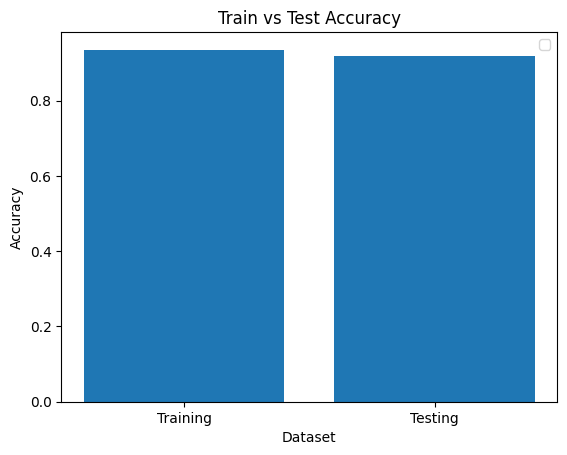

In [9]:
import json
import matplotlib.pyplot as plt

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def find_best_config(data):
    min_test_loss = float('inf')
    best_config = None

    for key, value in data.items():
        current_test_loss = value['test_loss']

        if current_test_loss < min_test_loss:
            min_test_loss = current_test_loss
            best_config = value

    return best_config

def plot_accuracy_epochs(config):
    # Assuming the epochs are not provided in this format, you may need to modify accordingly
    train_accuracy = config.get('train_accuracy', [])  
    test_accuracy = config.get('test_accuracy', [])
    # epochs = list(range(1, len(train_accuracy) + 1))

    # Bar chart instead of line plot
    bar_width = 0.35
    plt.bar(["Training", "Testing"], [train_accuracy, test_accuracy])
    
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy')
    plt.legend()
    plt.show()

file_path = 'fashion_mnist_grid_search_results.json'
json_data = read_json_file(file_path)

best_config = find_best_config(json_data)
print(f"Best Config with least test loss: {best_config}")

# Plotting train vs test accuracy for the best config
plot_accuracy_epochs(best_config)


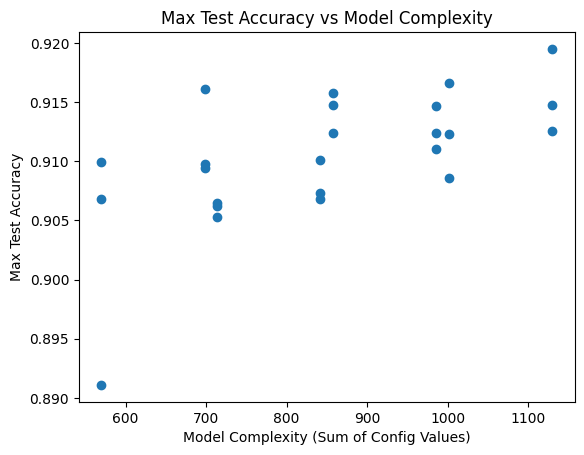

In [5]:
import json
import matplotlib.pyplot as plt

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def plot_max_accuracy_vs_complexity(data):
    complexities = []
    max_test_accuracies = []

    for key, value in data.items():
        config_str = key.replace("'", "\"")  # Replace single quotes with double quotes
        config_dict = json.loads(config_str)
        
        complexity = config_dict['conv1_out_channels']*9+config_dict['conv2_out_channels']*9+config_dict['fc1_out_features']+10
        max_test_accuracy = value['test_accuracy']

        complexities.append(complexity)
        max_test_accuracies.append(max_test_accuracy)

    plt.scatter(complexities, max_test_accuracies)
    plt.xlabel('Model Complexity (Sum of Config Values)')
    plt.ylabel('Max Test Accuracy')
    plt.title('Max Test Accuracy vs Model Complexity')
    plt.show()

file_path = 'fashion_mnist_grid_search_results.json'
json_data = read_json_file(file_path)

# Plotting max test accuracy vs model complexity
plot_max_accuracy_vs_complexity(json_data)
